# How to delta hedge an option: Part I

## Intuition, the basics and more intuition

When learning the basics of derivatives trading it's not an exaggeration to say that I was pretty useless for the best part of 6-12 months. Phrases like 'risk neutral measure' and 'Ito calculus' followed by appeals to books with pages littered with stochastic differential equations strangely didn't clarify the basic ideas of delta and gamma hedging in my head.

As time went on I realised the factors causing this confusion could largely be grouped in two:
 - my constant confusion between the valuation of derivatives based on _statistical_ arguments vs _replication_ arguments
 - I learn best with concrete examples using graphs or simulations, rather than theoretical ideas

The following series of articles is a replication (pardon the pun) of some of my notes on how an option is valued using as little mathematical formulae as possible and appealing to 'trader-like' replication arguments instead.

## What is an option?

For the sake of everything below an 'option' will refer to a 'vanilla call option'. There also exist 'put options'  but we don't need to worry about them for now - Put-Call parity ensures that almost all points made about call options applies to put options. To use the classic definition recited almost `100/100` when someone is asked to define a call option:

_"A call option gives you the right __but not the obligation__ to buy a stock at a fixed strike price at the time of expiration."_

The bit in bold is usually the bit where people change their tone of voice. To me this is the kind of definition that makes immediate sense _if you already know what a call option is_; and if not then it just has a lot of jargon. Which means it's not a very enlightening definition. To make sense of this in simple terms we first need to understand why you would buy or sell a stock.

## Why would I buy a stock?

Because you think it's going up (forget about divs/voting rights for now). If a stock goes up by 1, then you make 1. If a stock goes up by 2, then you make 2 (this can get boring quite quickly). However for the chance to make 'linearly' as just described if the stock goes up, you wil also lose if the stock goes down. If it goes down 1, then you lose 1 etc etc. To really over-engineer the point, but for the sake of clarity, we can draw this on a graph below.

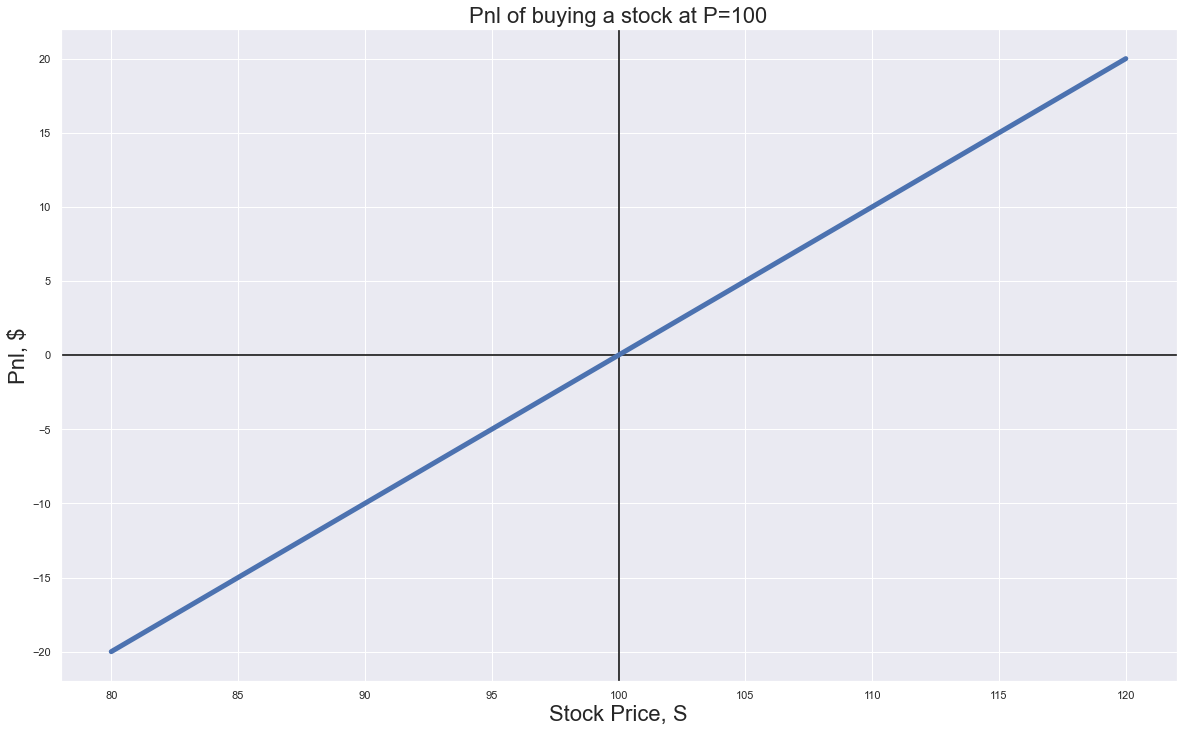

In [5]:
# import the usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set()

pxs = np.linspace(80, 120, 41)
pnls = pxs - 100

fig, ax = plt.subplots(figsize=(20,12))
ax.axhline(0, color='black')
ax.axvline(100, color='black')
ax.plot(pxs, pnls, lw=5)

ax.set_title('Pnl of buying a stock at P=100', fontsize=22)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Pnl, \$', fontsize=22);

The graph above has the stock price on the x-axis and the 'PnL' ('Profit and Loss' - just how much money you make or lose) on the y-axis. So we can see that if the stock price, `S`, goes up to `105` then we make `5`. Similarly given it is 'linear' then if it goes down by `5` to `95` then we lose `5`. So far, so simple.

## Why would I buy a (call) option?

So clearly in the above graph we have a symmetric payoff - if it goes up we make and if it goes down we lose equally. A call option allows us to escape this world (yay!!!). If the stock goes up then we get to keep hold of those juicy juicy gains but if it goes down we don't need to worry about it. Magic.

Again, to make things pictorial we can plot this relationship between the PnL of a call option and the 'underlying' stock price on a graph.

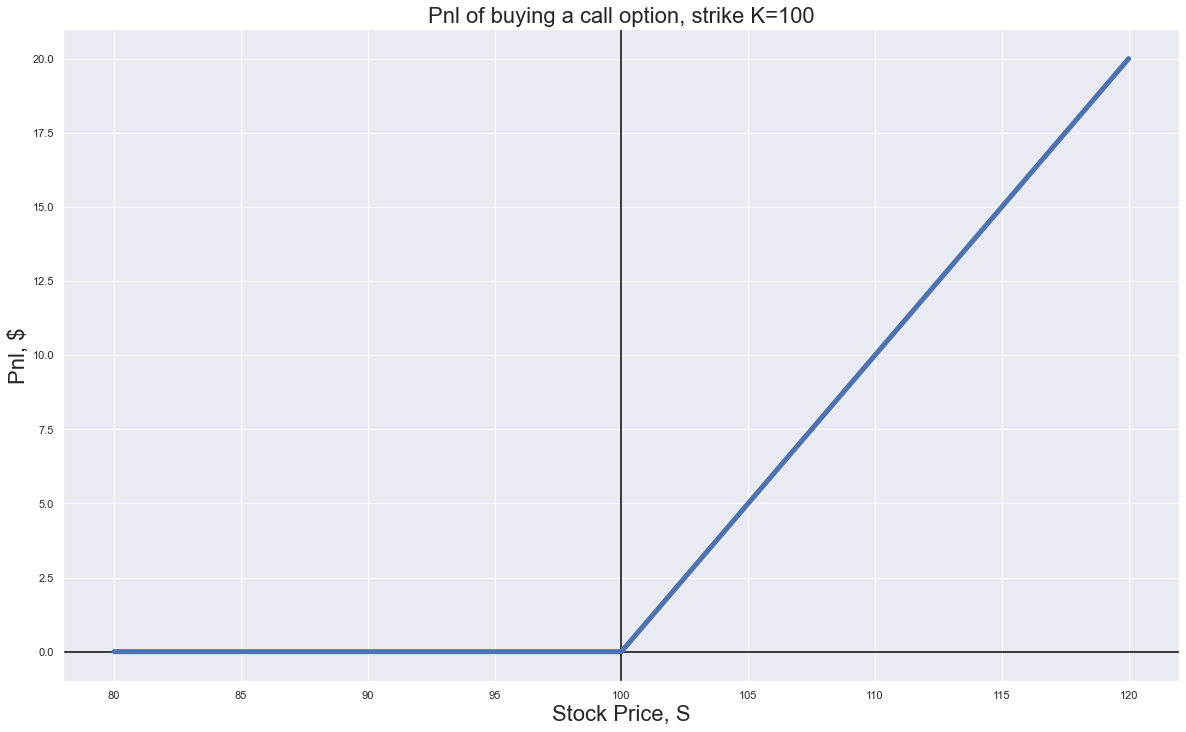

In [6]:
pxs = np.linspace(80, 120, 41)
pnls = [max(0, s - 100) for s in pxs]

fig, ax = plt.subplots(figsize=(20,12))
ax.axhline(0, color='black')
ax.axvline(100, color='black')
ax.plot(pxs, pnls, lw=5)

ax.set_title('Pnl of buying a call option, strike K=100', fontsize=22)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Pnl, \$', fontsize=22);

So the above graph shows the payoff of a call option with a 'strike' of `100` (this is commonly given the letter `K`). This is just the price at which if the stock goes above we get to keep hold of the money. The above shows that for a call option just as before if the stock goes up by `5` to `105` then we will make `5`, however now if it falls by a similar amount we are 'protected' - we lose nothing.

The benefit of this is obvious - we now seem to have converted a symmetric payoff (win equally on the upside vs downside) into an asymmetric one - we just always win.

## What's the catch?

If the above is true why doesn't everyone buy call options? __Because if the above was true then nobody would sell call options.__ We've left out the key detail that in order to get the above graph where you always win __you have to buy it__. The above belongs in the world where lottery tickets are free and all insurance premiums are zero - a world where you get potential wins for zero cost.

Unfortunately to get the above payoff you need to pay a 'premium' for it. If we factor in paying a premium, `P`, for it then we translate the graph a bit lower and end up with:

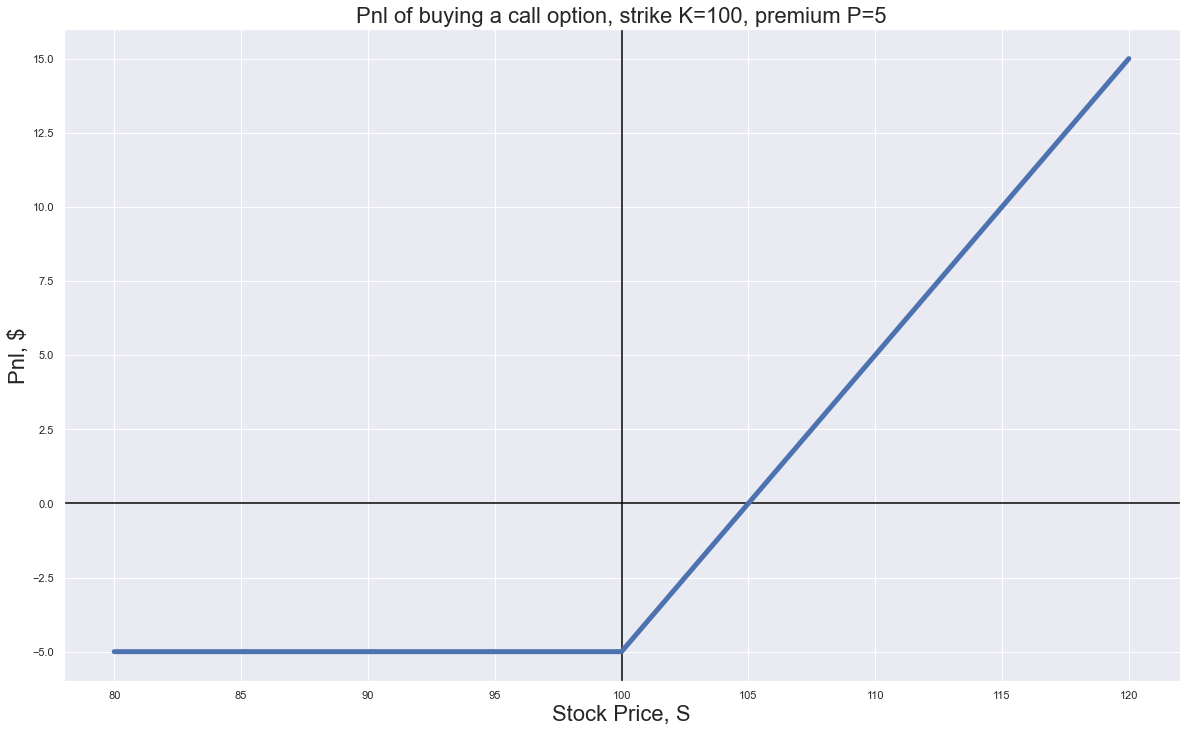

In [7]:
K = 100
p = 5
pxs = np.linspace(80, 120, 41)
pnls = [max(0, s - K) - p for s in pxs]

fig, ax = plt.subplots(figsize=(20,12))
ax.axhline(0, color='black')
ax.axvline(100, color='black')
ax.plot(pxs, pnls, lw=5)

ax.set_title('Pnl of buying a call option, strike K={}, premium P={}'.format(K, p), fontsize=22)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Pnl, \$', fontsize=22);

Now we don't look as good - instead of only ever making we now have a scenario where we pay a fixed cost to:
 - make sure we still make if the stock goes up (enough)
 - lose a fixed amount if the stock goes down, no matter how much it goes down (instead of losing linearly with the stock price fall)

How willing we are to then buy the above 'payoff graph' clearly depends on the following trade-off:
 - how much the option costs (how much we have to shift the above graph lower by)
 - where we expect the stock to end up on the graph - if we think it will end up way off to the right (or even a chance of it) - then we may still be willing to pay a lot for the option

which then begs the central question:

## How do you work out how much the above payoff should cost?

This is the central idea of derivatives trading - figuring out how much you think it's fair to shift the graph down by when you are buying or selling an option. Below are some fairly simple approaches.

## Charge the maximum

If you are looking to make a business out of selling the above call options then one strategy is to find out what the maximum you can lose is - then just charge that amount. If you think the maximum amount you can lose is `100` (that would mean the stock price finishes at `200` in our above example) then just charge `100`.

That way if the worst comes to worst you can just give them back the `100` that you charged and you lose nothing, and in all the other scenarios you should make a variable amount depending on how much the underlying stock goes up.

## Charge slightly more than historically

Another approach might be to look at what the exact same call option would have paid out historically, then charge that much plus a little bit extra so that if you do this lots and lots of times over you _should_ 'average in' and make that little bit. So if historically you see that it paid out `4`, `6`, `0`, `8`, `0` giving an average of `5` then how about you charge `6`? That way if you do this over and over you would 'expect' to make `1`.

## Something else

Unfortunately for our first strategy it seems like if we look at the graph there is actually no limit on what we could lose if we sold it. The stock price (in theory) could go up and up and up to a huge number and we would have to pay out `huge_number` - `100` as the payoff of the call option. Ideally what we want is some way of transforming the above payoff so that it no longer depends on the final stock price. One way we can have a go at this is to notice that __the call option's final price depends positively on the finishing stock price.__

## Naive first go at delta hedging

If we recognise this then we can make the following observation. If I buy a call option and if the 'underlying' stock price goes up then the call option's final value goes up. Similarly if it goes down then the call option's final value goes down. One way I can 'offset' (or hedge) these 'fluctuations' is by selling some of the stock. If I buy a call option then sell some stock:
 - if the stock goes up I make money on my call option going up in value and lose some money on the value of the stock I sold also going up
 - if the stock goes down then I lose money on my call option but will make some back on the value of the stock I sold going down

We can again show this graphically. The below shows the payoff if we combine the process of buying a call option with strike `K=100` when the underlying stock price is also at `100`, but we then also sell `0.5` stocks (let's ignore the fact we are talking about selling half a stock for now). Similar to the above let's assume we pay a premium of `P=5` for the call option.

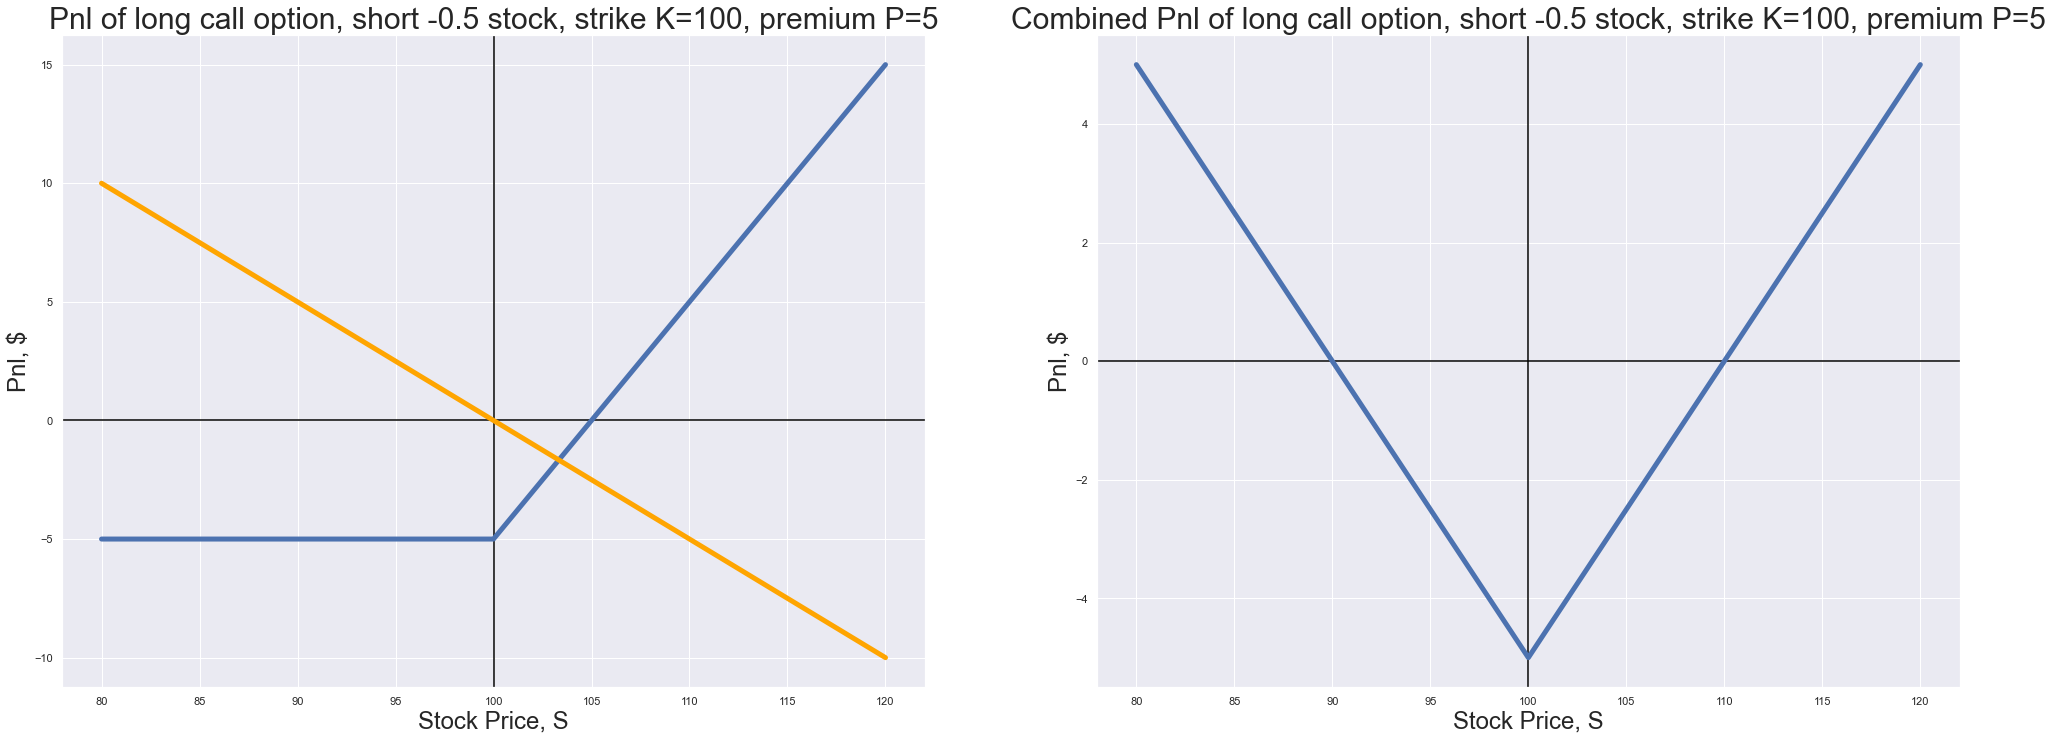

In [8]:
K = 100
S = 100
p = 5

delta = -0.5
pxs = np.linspace(80, 120, 41)
call_pnls = [max(0, s - K) - p for s in pxs]
stock_pnls = delta * (pxs - S)

fig, axes = plt.subplots(ncols = 2, figsize=(34,12))
axes = axes.reshape(-1)

axes[0].axhline(0, color='black')
axes[0].axvline(100, color='black')
axes[0].plot(pxs, call_pnls, lw=5)
axes[0].plot(pxs, stock_pnls, lw=5, color='orange')

axes[0].set_title('Pnl of long call option, short {} stock, strike K={}, premium P={}'.format(delta, K, p), fontsize=30)
axes[0].set_xlabel('Stock Price, S', fontsize=24)
axes[0].set_ylabel('Pnl, \$', fontsize=24);

axes[1].axhline(0, color='black')
axes[1].axvline(100, color='black')
axes[1].plot(pxs, call_pnls + stock_pnls, lw=5)

axes[1].set_title('Combined Pnl of long call option, short {} stock, strike K={}, premium P={}'.format(delta, K, p), fontsize=30)
axes[1].set_xlabel('Stock Price, S', fontsize=24)
axes[1].set_ylabel('Pnl, \$', fontsize=24);

Let's start with the graph on the left. We have the same 'hockey stick' blue line that refers to the call option payoff at expiry assuming we paid `5` for it and it has a strike price `K=100`. We then have a negative sloping orange line - this represents the stock that we _sell_. We don't sell `1` stock but instead only sell `0.5` so that e.g. if the stock goes up `20` and finishes at `120` we only lose `10` not `20` and vice versa on the downside. This choice to sell `0.5` is arbitrary for now but will be explained later.

The graph on the right then shows what happens if we combine these two lines (or payoffs). If the stock goes down then we will make some money on the stock that we have sold (called 'short selling' the stock) and if the stock goes up then we have 2 offsetting effects:
 - we lose some money on that same stock we have sold
 - we make money on the value of our call option going up

Overall we have now through selling some stock converted our 'hockey stick' style graph back into something that is symmetric. It's almost like we don't care if the stock goes up or down - we just want it to move. By how much? Well we need it to move by at least `10` (where the combined line crosses the x-axis) so that we make money. If the premium `P=5` that we paid for the option was less then we wouldn't need it to move so much for us to make money on this combined payoff.

## Where did the `0.5` come from?

I just kind of made it up (sort of). But in the above example it works out nicely in transforming our graph. If we were way over on the right of the graph though then `0.5` looks like a bad choice. Why? Well because if we are way above our strike (the kink in the graph) then the value of the call option moves 'linearly' with the stock price. If the stock price goes up from `130` to `140` then it looks like our call option would also go up by `10` - from `30` to `40`.

Similarly if we are way below our strike price then it seems like the call option price doesn't respond to the value of the stock price - a fall of `10` from `70` to `60` probably still leaves the call option worth `0`. And then somewhere in the middle we sit inbetween - maybe with a 'sensitivity' of the call option to the stock price of around `0.5`.

## Moving away from 'terminal payoffs'

To expand on this idea further we need to move away from terminal payoffs. Implicit in the above explanation of everything is the idea that everything is 'valued' at a certain point in time. At some point in time, `T`, we are going to check the stock price,, `S`, compare it to our strike price `K`, and then compute the final value of our option. If `S > K` then the option will be worth something otherwise it will be worth `0`.

However what about _before_ this final point in time (called 'expiry' or 'expiration')? Pre-expiration we still want to know how much the option is worth - maybe because we don't want to wait until expiry to sell it. If we still have `t` days left until expiry then we need to figure out what these `t` days are worth. Is it beneficial to have more time until expiry or less?

## Time value is always positive

This value of time is very simply called 'time value' and for a vanilla (European - ignore for now) call option this is always positive - it's always better to have more time to expiry than less. This can be seen by using a simple iterative example. Let's say you have a call option with the following details:
 - `t=1` day left until expiry
 - `K=100` as a strike price
 - `S=99` as the stock price

So we have 1 day left to expiry and the stock price is _just_ below the strike price. I come along and say I'll buy your call option off you for `0` - do you sell it? Hopefully not. Why? Well because even though we're below the strike price of `100`, we still have some time left. We have 1 day left where the stock price _might_ increase to above `100` at which point your call option will be worth something. Sure, it might also fall in which case it will be worthless but it's already going to be worthless at the current stock price of `99`.

In other words, because time brings with it the possibility of the option being worth something then you should have to pay for it - this is the 'time value'. What about if we take the previous example but instead our stock price is `60` below the strike at `S=40`. Does this scenario have the same time value?

Probably not. Why? Because we are assuming that it is much more likely for the stock price to go up by `2` or `3` in our previous example to 'cross the strike' and be worth something than for it to shoot up by `60` (increase by 150% in 1 day). Because we assume that stocks are more likely to make small moves than large moves then the time value of an option with a stock price well below the strike price is much less.

## Recap

The above has been fairly wordy so far but I think that's preferable to a load of mathematical equations that provide no intuition. To summarise before we move on with more graphs, we have established that:
 - call options' prices are positively related to the underlying stock price
 - this sensitivity varies - between `0` when we are way below the strike and `1` when we are way above the strike
 - time has value - we'd rather own a call option with more time to expiry because this gives us a chance that if we are below the strike we may still move above the strike before expiry and so the call option will have value

and with that in mind let's continue on to see how option values look pre-expiry and run through an intuitive example of how time value is _the result of_ the opportunity to delta hedge - they are in essence two sides of the same coin.